# VAR GLLVM

 ## Model Specification

Let  $y_{i1t},y_{i2t},\ldots,y_{ipt}$  be a set of $p$ response or observed variables at time $t,\ t=1,\ldots,T$ for  individual $i,\ i=1,\ldots,n$. Let $\mathbf{x}_{it}$ be a set of observed $k$-dimensional covariates at time $t,\ t=1,\ldots,T$.

Models for multivariate longitudinal data have to account for the three sources of variability
present in the data, that is (i) cross-sectional associations between the responses at a particular time point, (ii) cross-lagged
associations between different responses at different occasions, and  (iii) the association between repeated measures of the same response
over time. The first source of variability is accounted for
a time-dependent latent variable $z_{i1}, z_{i2},\ldots,z_{iT}$. Modeling the temporal evolution of the latent variable acpoisson for the cross-lagged associations between different responses over time.
The third source of variability can be accounted for a set of item-specific random effects $\mathbf{u}_{i}=(u_{i1}, \ldots, u_{ip})'$.

According to the GLLVM framework we have

\begin{align*}
   \nonumber y_{ijt}|\mu_{ijt} &\sim \mathcal{F}_j(y_{ijt}\vert \mu_{ijt}, \tau_j)\\
   \mu_{ijt}&=  g_j(\eta_{ijt})=g_j(\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij}\sigma_{u_j})\\ %  \label{eqn:GLLVM-model2}
\end{align*}
where $g_j(\cdot),j=1,\ldots,p$ is a known {\it link function}, $\eta_{ijt}=\beta_{0jt} + \mathbf{x}_{i}^{\top}\boldsymbol \beta_{jt} + z_{it}^{\top}\lambda_{jt}+u_{ij},i=1,\ldots,n,j=1,\ldots,p, t=1,\ldots,T$ is the {\it linear predictor},  and $\mathcal{F}_j(y_{ijt}\vert \eta_{ijt}, \tau_j)$ denotes a distribution from the exponential family with mean $\mu_{ijt}$ and response variable-specific dispersion parameter $\tau_j$. \vspace{5pt}\\
The dynamics of the latent variable over time is modelled through a stationary vector-autoregressive model of first order


$$
z_{i,t} = Az_{i,t-1} +  \epsilon_{i,t}\\
||A||_2 < 1\\
\epsilon_{i,t} \sim N(0, I)\\
$$

initialization for $t=0$:

$$
z_{i, 1} \sim N(0, \Sigma_{z1})\\
\Sigma_{z1} = 
\begin{pmatrix}
    \sigma_{z1,1}^2&\\
    &\sigma_{z1,2}^2
\end{pmatrix}\\
\sigma_{z1,i}>0 \forall i
$$

Moreover, we assume the random effects independent of the latent variable and their common distribution $\mathbf{u}_{i}\sim N_p(\mathbf{0}, \boldsymbol I)$.


### Estimating $\epsilon, u$
To estimate $z, u$, we use a neural network. The training of the neural network is guided by the knowledge of the parameters. In essence, the neural network learns to  estimate the linear parameter from the responses (or transformation thereof), which is an easy task. Once the linear parameter is known, we obtain the Z as coefficients for lambda and u_scaled as reminders. (since the goal is to estimate z and u given the parameter values, we can use them). Once we have z, we can get epsilon. We then rescale all variables using the known parameters so all epsilon and u are N(0,I), and thus directly comparable on precisely the same scale. We then use MSE on all these together to train the neural network. Even though it is a multi-objective, we know their weights. This provides speedups of several orders of magnitudes, compared to computing the solution directly.



# TODO:
* test that the operations in forward are correct
* in the forward fct ofthe encoder, test that the gradients of the model used as argument are NOT CHANGED
* create a set_A function in VARGLLVM to set both parameters of VARGLLVM and the other in VAR1

In [454]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_value_
import numpy as np
from VAR1 import VAR1
from typing import Type, Optional, Tuple
import matplotlib.pyplot as plt

class VARGLLVM(nn.Module):
    """
    Vector Autoregressive Generalized Linear Latent Variable Model (VAR GLLVM) for multivariate longitudinal data.
    
    This class provides a multivariate extension of GLLVM, modeling multivariate responses over time.
    The variability in the data is captured through three sources: cross-sectional associations,
    cross-lagged associations, and associations between repeated measures of the same response over time.
    The model specification integrates a time-dependent latent variable and an item-specific random effect.
    
    Parameters:
    - num_var: int, Number of response variables.
    - num_latent: int, Number of latent variables.
    - num_covar: int, Number of observed covariates.
    - response_types: dict, Mapping of response type to its indices.
    - add_intercepts: bool, Whether to include intercepts in the model.
    
    Key Methods:
    - forward: Computes the conditional mean of the model.
    - sample: Draws samples from the VARGLLVM model.
    - sample_response: Samples from the response distribution based on conditional mean.
    - linpar2condmean: Converts linear predictors to conditional means.

    Model Specification:
    y_{ijt}|μ_{ijt} ~ F_j(y_{ijt}|μ_{ijt}, τ_j)
    μ_{ijt} = g_j(β_{0jt} + x_{it}^T*β_{jt} + z_{it}^T*λ_{jt}+u_{ij}*σ_{u_j})
    
    Where:
    - g_j: link function
    - μ_{ijt}: mean of the distribution
    - F_j: a distribution from the exponential family
    - η_{ijt}: linear predictor

    Temporal evolution of the latent variable:
    z_{it} = A*z_{i,t-1} + ε_{it}
    with ε_{it} ~ N(0, I) and initialization z_{i, 1} ~ N(0, Σ_{z1}).
    
    The random effects are assumed independent of the latent variable and distributed as:
    u_{i} ~ N_p(0, I).
    """
    
    def __init__(self, num_var, num_latent, num_covar, response_types, add_intercepts = True):
        super().__init__()
        self.response_types =  response_types
        self.response_link = {
            'bernoulli' : lambda x: torch.logit(x),
            'ordinal': lambda x: torch.logit(x),
            'poisson': lambda x: torch.log(x)
        }
        self.response_linkinv = {
            'bernoulli': lambda x: 1/(1+torch.exp(-x)),
            'ordinal': lambda x: 1/(1+torch.exp(-x)),
            'poisson': lambda x: torch.exp(x)
        }
        self.transform_functions = {
            'bernoulli' : lambda x: 2*x - 1,
            'ordinal': lambda x: 2*x - 1,
            'poisson': lambda x: torch.log(x+1)
        }

        self.num_var = num_var
        self.num_latent = num_latent
        self.num_covar = num_covar

        # Define Parameters
        # -----------------
        # Parameters for the VAR
        self.A = nn.Parameter(torch.zeros((num_latent, num_latent)))
        self.logvar_z1 = nn.Parameter(torch.zeros((num_latent,)))

        # Parameters for the outcome model
        if add_intercepts:
            self.intercepts = nn.Parameter(torch.zeros((num_var,)))
        else:
            self.intercepts = None

        self.wz = nn.Parameter(torch.randn((num_latent, num_var)))
        self.wx = nn.Parameter(torch.randn((num_covar, num_var)))

        # Parameters for the random effects
        self.logvar_u = nn.Parameter(torch.zeros((num_var,)))
        
        # Define Modules
        # --------------
        self.VAR1 = VAR1(A=self.A, logvar_z1 = self.logvar_z1)

    def forward(self, epsilon, u, x = None):
        """
        Compute the conditional mean of a VARGLLVM

        Parameters:
            - epsilon: shocks for the VAR
            - u: shocks for the random effects
            - x: covariates
        """
        assert epsilon.shape[2] == self.num_latent, "bad shape for epsilon"
        assert u.shape[1:] == (1, self.num_var), "bad shape for u"

        # Computing linpar
        # ----------------
        linpar = torch.zeros((epsilon.shape[0], epsilon.shape[1], self.num_var))

        # add intercepts, one per variable
        if self.intercepts is not None:
            linpar += self.intercepts[None, None, :]

        # add covariates' effects
        if x is None:
            assert self.num_covar == 0, f'VARGLLVM module expected {self.num_covar} covariates, received {0}.'
        else:
            assert(x.shape[1:] == (epsilon.shape[1], self.num_covar))
            linpar += x @ self.wx

        # add latent variables' effects
        z = self.VAR1(epsilon)
        linpar += z @ self.wz

        # finally, add random effects
        linpar += u * torch.sqrt(torch.exp(self.logvar_u[None, None, :])) # we add a time dimension: u is the same across time!
        
        # compute the conditional mean
        condmean = self.linpar2condmean(linpar)
        return (linpar, condmean)
    
    def sample(self, batch_size, seq_length,  x = None, epsilon = None, u = None):
        """
        Sample from the VARGLLVM. 

        Parameters:
            - batch_size: number of observational units
            - seq_length: length of the sequence. if any of x, epsilon, or u are provided, their seq_length must coincide
            - x: tensor of shape (batch_size, seq_length, num_covar). If the VARGLLVM model was initialized with num_covar >= 1, cannot be None.
            - epsilon: the shocks for the latent variables of shape (batch_size, seq_length, num_latent). If None, those are drawn iid from N(0, 1).
            - u: the shocks for the random effects of shape (batch_size, 1, num_var). If None, those are drawn iid from N(0, 1).

        """
        if epsilon is None:
            epsilon = torch.randn((batch_size, seq_length, self.num_latent))
        if u is None:
            u = torch.randn((batch_size, 1, self.num_var)) # one per var, but constant across time
        
        linpar, condmean = self(epsilon, u, x)
        y = self.sample_response(condmean)

        return {"epsilon": epsilon, "u": u, "linpar": linpar, "condmean":condmean, "y":y, "x":x}

    def sample_response(self, mean):
        device = next(self.parameters()).device
        y = torch.zeros_like(mean).to(device)
        for response_type, response_id in self.response_types.items():
            if response_type == "bernoulli":
                y[:,:,response_id] = torch.bernoulli(mean[:,:,response_id]).to(device)
            elif response_type == "ordinal":
                cum_probs = mean[:,:,response_id]
                # draw one uniform for the whole vector
                random = torch.rand((*cum_probs.shape[0:2], 1)).to(device)
                # compare with the cumulative probabilities
                ordinal = torch.sum(random > cum_probs, dim=2)
                ordinal = torch.nn.functional.one_hot(ordinal).squeeze().float()
                ordinal = ordinal[:,:,1:] # discard the first column of the one_hot encoding, as it is superfluous (as a 0)
                y[:,:,response_id] = ordinal
            elif response_type == "poisson":
                y[:,:,response_id] = torch.poisson(mean[:,:,response_id])
        return y
    
    def linpar2condmean(self, linpar):
        mean  = torch.zeros_like(linpar)
        for response_type, response_id in self.response_types.items():
            mean[:,:,response_id] = self.response_linkinv[response_type](linpar[:,:,response_id])
        return mean
    
    def transform_responses(self, y, transform_functions=None):
        """
        Transform the responses according to their types.

        Parameters:
            - y: a (batch_size, seq_length, num_var) tensor
            - transform_functions: a dictionary with keys:values corresponding to response_type: lambda x: transform(x). Defaults to the default transforms of VARGLLVM
        """

        if transform_functions is None:
            transform_functions = self.transform_functions

        y_transformed = torch.zeros_like(y)
        for response_type, response_id in self.response_types.items():
            y_transformed[:,:,response_id] = self.transform_functions[response_type](y[:,:,response_id])

        return y_transformed


    
    def _get_device(self):
        return next(self.parameters()).device

class MELoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y, linpar, ys, linpars, mask=None):
        """Computes the loss. hat is recontructed y, ys is simulated"""
        loss = -torch.sum(y * linpar - ys * linpars) / y.shape[0] 
        return loss


In [455]:
class Encoder(nn.Module):
    """
    Learns the shocks epsilon and u of a VARGLLM, such that when passed through VARGLLM we get the reconstruction.
    
    Parameters:
        - num_var: number of responses
        - num_covar: number of covariates (columns of x)
        - num_latent: dimension of latent variables (for a single period)
        - num_hidden: number of hidden units. I would advise fully connected except for large number of covar
    """
    def __init__(self, num_var: int, num_covar: int, num_latent: int, num_hidden: int):
        super().__init__()
        
        self.num_var = num_var
        self.num_covar = num_covar
        self.num_latent = num_latent

        self.fc = nn.Sequential(
            nn.Linear(num_var + num_covar, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            # nn.Linear(num_hidden, num_hidden),
            # nn.Tanh(),
            nn.Linear(num_hidden, num_latent + num_var)
        )

    def forward(self, y: torch.Tensor, VARGLLVM_model: Type[nn.Module], x: Optional[torch.Tensor]=None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict z, u given y,x, and a VARGLLVM_model

        Parameters:
            y: a (batch_size, seq_length, num_var) Tensor of responses
            x: a (batch_size, seq_length, num_covar) Tensor of covariates
            VARGLLVM_model: a VARGLLVM model in eval mode.
        """
        
        # Flag VARGLLVM_model
        # -------------------
        
        # First we set the model in eval mode
        VARGLLVM_model.eval()
        # We need to turn off the requires_grad of all VARGLLVM_model parameters, and then restore them to their original state
        # Store the original requires_grad flags
        # TODO: do we reall need to do this here? Do it outside imho.
        original_flags = [p.requires_grad for p in VARGLLVM_model.parameters()]

        # Set requires_grad to False for all parameters of VARGLLVM_model
        for param in VARGLLVM_model.parameters():
            param.requires_grad = False
        
        # Forward pass
        # ------------
        if x is None:
            xy = y
        else:
            xy = torch.cat((y, x), dim=2)
        
        seq_length = y.shape[1]
        out = self.fc(xy.view(-1, self.num_var + self.num_covar)).view(-1, seq_length, self.num_latent + self.num_var)

        out_z = out[:, :, :self.num_latent]
        out_epsilon = VARGLLVM_model.VAR1.backward(out_z)

        out_u_scaled = out[:, :, self.num_latent:]
        out_u = out_u_scaled / torch.sqrt(torch.exp(VARGLLVM_model.logvar_u[None, None, :]))
        out_u = torch.mean(out_u, dim=1).unsqueeze(1)
        
        # Set Flags of VARGLLVM_model back
        # ---------------------------------
        # Restore the original requires_grad flags
        for param, flag in zip(VARGLLVM_model.parameters(), original_flags):
            param.requires_grad = flag


        return (out_epsilon, out_u)
    


## Training Loops

In [456]:
def train_encoder(encoder, VARGLLVM_model, criterion, optimizer, num_epochs=100, sample=True, batch_size=None, seq_length =None, x=None, data=None, verbose=False):
    """
    Trains the given encoder model using the provided data and parameters.

    Parameters:
    - encoder: The encoder model to be trained.
    - model: VARGLLVM model for response transformation.
    - data_true: Ground truth data dictionary with 'y' and 'epsilon' keys.
    - x: Input data.
    - num_epochs (optional): Number of epochs for training.
    - lr (optional): Learning rate for the Adam optimizer.
    - num_hidden (optional): Number of hidden units.
    - num_covar (optional): Number of covariates.
    - num_latent (optional): Number of latent variables.
    - data: if sample is False, takes data from data
    
    Returns:
    - A trained encoder.
    """
    encoder.train()
    VARGLLVM_model.eval()

    if data is not None:
        if sample:
            print("Sample is True: supplied 'data' is ignored.")
        with torch.no_grad():
            y_transformed = VARGLLVM_model.transform_responses(data['y'])

    num_latent = VARGLLVM_model.wz.shape[0]
    num_var  = VARGLLVM_model.wz.shape[1]
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        if sample:
            with torch.no_grad():
                data = VARGLLVM_model.sample(batch_size, seq_length, x=x)
                y_transformed = VARGLLVM_model.transform_responses(data['y'])       

        epsilon, u = encoder(y=y_transformed, VARGLLVM_model=VARGLLVM_model, x=data['x'])
        
        tot_weight = num_var + num_latent
        loss = (criterion(epsilon, data['epsilon']) * num_latent/tot_weight +
                criterion(u, data['u']) * num_var/tot_weight)
        
        loss.backward()
        optimizer.step()
        if verbose:
            print(f'Epoch {epoch}, loss {loss.item()}.')

    return loss.item()

def train_decoder(model, encoder, criterion, optimizer, data, num_epochs=100, transform=False, verbose=True, clip_value=0.05):
        batch_size = data['y'].shape[0]
        seq_length = data['y'].shape[1]

        # Training loop
        model.train()
        encoder.eval()
        # We start by training the encoder

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            
            with torch.no_grad():
                # # simulate
                data_sim = model.sample(batch_size, seq_length, data['x'])
                # # train encoder

                # encode
                data_epsilon, data_u = encoder(data['y'], model, data['x'])
                data_sim_epsilon, data_sim_u = encoder(data_sim['y'], model, data_sim['x'])
            
            linpar, _ = model(data_epsilon, data_u, data['x'])
            linpar_sim, _ = model(data_sim_epsilon, data_sim_u, data['x'])
            
            if transform:
                with torch.no_grad():
                    y = model.transform_responses(data['y']) 
                    y_sim = model.transform_responses(data_sim['y'])
            else :
                y = data['y']
                y_sim = data_sim['y']
            loss = criterion(y, linpar, y_sim, linpar_sim)
            
            loss.backward()
            clip_grad_value_(model.parameters(), clip_value=clip_value)
            optimizer.step()
            

            if verbose: 
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
            
        return loss.item()

In [457]:
batch_size = 10
num_var = 10
num_latent = 2
num_covar = 3
seq_length = 9
x = torch.randn((batch_size, seq_length, num_covar))

response_types = {
    'bernoulli': np.arange(5),
    'poisson': np.arange(5, num_var)
}

model = VARGLLVM(num_var = num_var,
                 num_latent = num_latent,
                 num_covar = num_covar,
                 response_types = response_types,
                 add_intercepts=False)

encoder = Encoder(num_var, num_covar, num_latent, num_hidden=10)

with torch.no_grad():
    model.A[:] = torch.Tensor([[0.8, 0.2], [0.1, 0.6]]) # include some amount of auto-correlation
    data_true = model.sample(batch_size, seq_length=seq_length, x=x)

In [458]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to device
# Move the models and data to device
encoder = encoder.to(device)
model = model.to(device)
data_true = {key:value.to(device) for key, value in data_true.items()} # Moving data to the device


# Define optimizer and criterion as before
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.01)
encoder_criterion = nn.MSELoss()

model_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model_criterion = MELoss()

# Define schedulers
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=10, gamma=0.1)
model_scheduler = torch.optim.lr_scheduler.StepLR(model_optimizer, step_size=10, gamma=0.1)


In [459]:

for i in range(100):
    print(i)
    encoder_loss = train_encoder(
        encoder, 
        model, 
        encoder_criterion, 
        encoder_optimizer, 
        num_epochs=10, 
        sample=True,
        batch_size=x.shape[0],
        seq_length=x.shape[1],
        x=x,
        data=data_true,
        verbose=False)
    
    encoder_scheduler.step()  # Step the encoder scheduler
    
    decoder_loss = train_decoder(
        model, 
        encoder, 
        model_criterion, 
        model_optimizer, 
        data_true,
        num_epochs=10, 
        transform=True,
        verbose=False)
    
    model_scheduler.step()  # Step the model scheduler


0
Sample is True: supplied 'data' is ignored.
1
Sample is True: supplied 'data' is ignored.


2
Sample is True: supplied 'data' is ignored.
3
Sample is True: supplied 'data' is ignored.
4
Sample is True: supplied 'data' is ignored.
5
Sample is True: supplied 'data' is ignored.
6
Sample is True: supplied 'data' is ignored.
7
Sample is True: supplied 'data' is ignored.
8
Sample is True: supplied 'data' is ignored.
9
Sample is True: supplied 'data' is ignored.
10
Sample is True: supplied 'data' is ignored.
11
Sample is True: supplied 'data' is ignored.
12
Sample is True: supplied 'data' is ignored.
13
Sample is True: supplied 'data' is ignored.
14
Sample is True: supplied 'data' is ignored.
15
Sample is True: supplied 'data' is ignored.
16
Sample is True: supplied 'data' is ignored.
17
Sample is True: supplied 'data' is ignored.
18
Sample is True: supplied 'data' is ignored.
19
Sample is True: supplied 'data' is ignored.
20
Sample is True: supplied 'data' is ignored.
21
Sample is True: supplied 'data' is ignored.
22
Sample is True: supplied 'data' is ignored.
23
Sample is True: su

In [460]:
encoded = encoder(y=model.transform_responses(data_true['y']), VARGLLVM_model=model, x=data_true['x'])

In [461]:
_, decoded_mean = model(data_true['epsilon'], data_true['u'], data_true['x'])

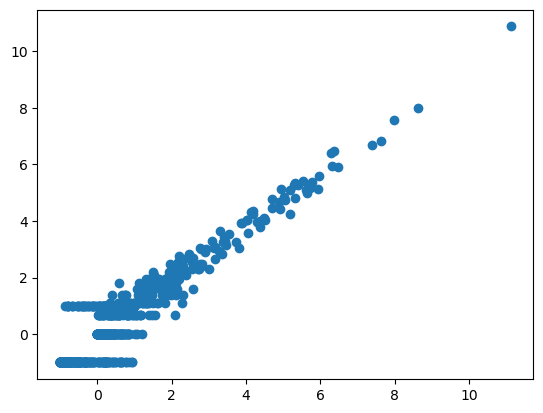

In [462]:
plt.scatter(model.transform_responses(decoded_mean).detach().numpy(), model.transform_responses(data_true['y']).detach().numpy())
plt.plot([0,])

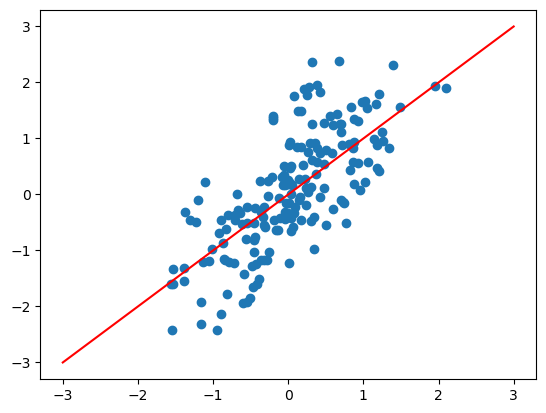

In [463]:
plt.scatter(encoded[0].detach(), data_true['epsilon'].detach())
plt.plot([-3,3], [-3,3], color="red")

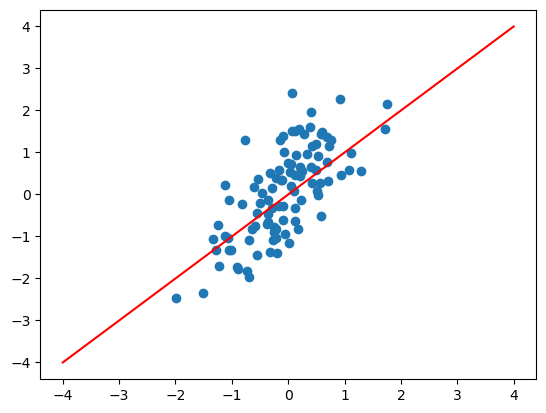

In [453]:
plt.scatter(encoded[1].detach(), data_true['u'].detach())
plt.plot([-4,4], [-4,4], color="red")